In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
pd.options.mode.chained_assignment = None

# Get Data

## From sii.cl

In [7]:
url = lambda x:'http://www.sii.cl/valores_y_fechas/uf/uf{}.htm'.format(x)

In [8]:
months_dict = {'Ene': '01', 'Feb': '02', 'Mar': '03',
               'Abr': '04', 'May': '05', 'Jun': '06',
               'Jul': '07', 'Ago': '08', 'Sep': '09',
               'Oct': '10', 'Nov': '11', 'Dic': '12'}

In [9]:
def getUF(year):
    df = pd.read_html(url(year))[-1]
    ts = df.unstack()
    ts = ts.reset_index()
    ts.columns = ["Month", "Day", "Price"]
    ts = ts[ts["Month"]!="Día"].reset_index(drop=True)
    ts = ts[(ts["Day"]!=0) & (ts["Price"].notnull())].reset_index(drop=True)
    ts["Date"] = str(year) +'-'+ ts["Month"].map(months_dict) + '-'+ ts["Day"].map('{:02}'.format)
    ts["Date"] = ts["Date"].astype("M8[us]")
    ts =  ts[["Date", "Price"]]
    return ts

In [16]:
ts = [getUF(year) for year in range(2014, 2021)] 
ts = pd.concat(ts, ignore_index=True)

In [17]:
ts.tail()

,Date,Price
1800,2020-01-04,28.31451
1801,2020-01-05,28.31542
1802,2020-01-06,28.31633
1803,2020-01-07,28.31725
1804,2020-01-08,28.31816


In [19]:
stamp = str(dt.date.today())
ts.to_csv("ufRaw_{}.csv".format(stamp),index=False)

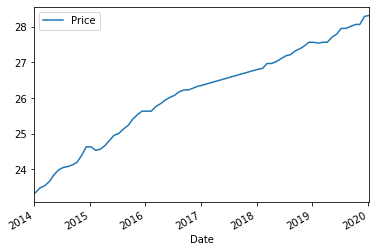

In [18]:
ts.plot(x="Date");

In [14]:
ts["Price"].pct_change().describe()

count    2118.000000
mean        0.000092
std         0.000094
min        -0.000259
25%         0.000032
50%         0.000067
75%         0.000161
max         0.000663
Name: Price, dtype: float64

In [15]:
ts.tail()

,Date,Price
2114,2019-12-26,28.30629
2115,2019-12-27,28.30721
2116,2019-12-28,28.30812
2117,2019-12-29,28.30903
2118,2019-12-30,28.30994


In [10]:
ts["Price"].pct_change().sum()

0.1674698917565952

## From valoruf.cl

In [2]:
url = lambda x: 'https://valoruf.cl/valores_anuales_uf_{}.html'.format(x)

In [3]:
%%time
year = 1979
dfs = pd.read_html(url(year))

CPU times: user 520 ms, sys: 69.6 ms, total: 589 ms
Wall time: 5.69 s


In [4]:
len(dfs)

12

Check this

```python
df["Price"] = np.frombuffer(df["Price"].values\
                                       .astype('|S7')\
                                       .tobytes().replace(b'$',b'')\
                                       .replace(b',',b'.'), dtype='|S6').astype("float64")
```

In [5]:
def processYear(year):
    dfs = pd.read_html(url(year))
    out = []
    month = 1
    for i, df in enumerate(dfs):
        if i%4!=0:
            df = df[1:]
            df.columns = ["Date", "Price"]
            df["Date"] = str(year) +'-'+\
                         "{:02}".format(month)+ '-'+\
                         df["Date"].astype(int).map('{:02}'.format)
            month +=1
            out.append(df)
    out = pd.concat(out, ignore_index=True)
    return out

In [6]:
%%time
uf = []
for year in range(1979, 2020):
    print(year)
    uf.append(processYear(year))
uf = pd.concat(uf, ignore_index=True)

1979


ValueError: invalid literal for int() with base 10: 'Viernes 2'

In [10]:
stamp = str(dt.date.today())
uf.to_parquet("ufRaw_{}.parq".format(stamp))

/home/baobob/.conda/envs/hybridDEV/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [11]:
uf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14189 entries, 0 to 14188
Data columns (total 2 columns):
Date     14189 non-null object
Price    14189 non-null object
dtypes: object(2)
memory usage: 221.8+ KB


In [12]:
uf["Date"] = uf["Date"].astype("M8[us]")

In [13]:
uf["Price"] = uf["Price"].str.replace("$", "")\
                         .str.replace(".", "")\
                         .str.replace(",", ".")\
                         .astype("float64")

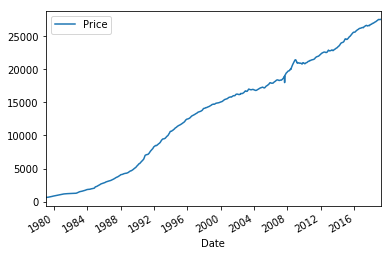

In [14]:
uf.plot(x="Date", y="Price");

In [15]:
stamp = str(dt.date.today())
uf.to_parquet("ufClean_{}.parq".format(stamp))

In [37]:
! ls -l --block-size=M

total 8M
-rw-r--r-- 1 baobob baobob 2M Nov 30 17:02 'Presentation Steps.ipynb'
-rw-rw-r-- 1 baobob baobob 1M Feb 22 10:39  ufClean_2019-02-22.parq
-rw-r--r-- 1 baobob baobob 1M Nov 23 13:33  ufCleanOld.parq
-rw-r--r-- 1 baobob baobob 3M Nov 28 12:12  uf_forecast_mcmc300.parq
-rw-r--r-- 1 baobob baobob 3M Nov 30 15:37  uf_forecast.parq
-rw-r--r-- 1 baobob baobob 1M Feb 22 10:38  UF.ipynb
-rw-r--r-- 1 baobob baobob 1M Feb 22 10:34  ufRaw.parq
-rw-rw-r-- 1 baobob baobob 1M Feb 22 10:39  ufRaw_stamp.parq


## Test conversion

In [74]:
%timeit uf["Price"].str.replace("$", "")\
                   .str.replace(".", "")\
                   .str.replace(",", ".")\
                   .astype("float64")

14.1 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
!

# Test conversion

In [177]:
%timeit df["Price"].str.replace("$", "")

111 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [180]:
%timeit np.frombuffer(df["Price"].values.astype('|S7').tobytes().replace(b'$',b'').replace(b',',b'.'), dtype='|S6')

5.52 µs ± 93.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [186]:
%timeit np.frombuffer(df["Price"].values.astype('|S7').tobytes().replace(b'$',b'').replace(b',',b'.'), dtype='|S6').astype("float64")

13.5 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [193]:
%timeit df["Price"].str.replace("$", "").str.replace(",", ".").astype("float64")

324 µs ± 8.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
